# **Super-Resolution Generative Adversarial Network training**

Here in this jupyter notebook, we will train a super-resolution generative adversarial network (SRGAN), to create a high-resolution Antarctic bed Digital Elevation Model(DEM) from a low-resolution DEM.
In addition to that, we use additional correlated inputs that can also tell us something about the bed topography.

<img src="https://yuml.me/diagram/scruffy;dir:LR/class/[BEDMAP2 (1000m)]->[Generator model],[REMA (100m)]->[Generator model],[MEASURES Ice Flow Velocity (450m)]->[Generator model],[Generator model]->[High res bed DEM (250m)],[High res bed DEM (250m)]->[Discriminator model],[Groundtruth Image (250m)]->[Discriminator model],[Discriminator model]->[True/False]" alt="3 input SRGAN model"/>

# 0. Setup libraries

In [1]:
import os
import random
import sys
import typing

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import comet_ml
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quilt
import skimage.transform
import tqdm

import chainer
import chainer.functions as F
import chainer.links as L
import cupy
import onnx_chainer

import keras
from keras import backend as K
from keras.layers import (
    Add,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Flatten,
    Input,
    Lambda,
)
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
import livelossplot

from features.environment import _load_ipynb_modules

print("Python       :", sys.version.split("\n")[0])
print("Numpy        :", np.__version__)
print("Chainer      :", chainer.__version__)
print("Keras        :", keras.__version__)
print("Tensorflow   :", K.tf.__version__)
K.tf.test.gpu_device_name()

Using TensorFlow backend.


Python       : 3.6.6 | packaged by conda-forge | (default, Oct 11 2018, 14:33:06) 
Numpy        : 1.14.5
Chainer      : 6.0.0b1
Keras        : 2.2.4
Tensorflow   : 1.10.1


''

In [2]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
# cupy.random.seed(seed=seed)
K.tf.set_random_seed(seed=seed)

# Start tracking experiment using Comet.ML
experiment = comet_ml.Experiment(
    workspace="weiji14", project_name="deepbedmap", disabled=False
)

COMET INFO: old comet version (1.0.42) detected. current: 1.0.43 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/weiji14/deepbedmap/4eba898b6160449a8fae53e58094c904



# 1. Load data

In [3]:
hash = "1ccc9dc7f6344e1ec27b7aa972f2739d192d3e5adef8a64528b86bc799e2df60"
quilt.install(package="weiji14/deepbedmap/model/train", hash=hash, force=True)
pkg = quilt.load(pkginfo="weiji14/deepbedmap/model/train", hash=hash)
experiment.log_parameter("dataset_hash", hash)

Fragments already downloaded


In [4]:
W1_data = pkg.W1_data()  # miscellaneous data REMA
W2_data = pkg.W2_data()  # miscellaneous data MEASURES Ice Flow
X_data = pkg.X_data()  # low resolution BEDMAP2
Y_data = pkg.Y_data()  # high resolution groundtruth
# W1_data = np.load(file="model/train/W1_data.npy")
# W2_data = np.load(file="model/train/W2_data.npy")
# X_data = np.load(file="model/train/X_data.npy")
# Y_data = np.load(file="model/train/Y_data.npy")
print(W1_data.shape, W2_data.shape, X_data.shape, Y_data.shape)

(2480, 100, 100, 1) (2480, 20, 20, 1) (2480, 10, 10, 1) (2480, 32, 32, 1)


## 1.1 Convert arrays for Chainer
- From Numpy (CPU) to CuPy (GPU) format
- From NHWC format to NCHW format, where N=number of tiles, H=height, W=width, C=channels

In [5]:
# Detect if there is a CUDA GPU first
try:
    cupy.cuda.get_device_id()
    xp = cupy
    print("Using GPU")

    W1_data = chainer.backend.cuda.to_gpu(array=W1_data)
    W2_data = chainer.backend.cuda.to_gpu(array=W2_data)
    X_data = chainer.backend.cuda.to_gpu(array=X_data)
    Y_data = chainer.backend.cuda.to_gpu(array=Y_data)
except:  # CUDARuntimeError
    xp = np
    print("Using CPU only")

Using GPU


In [6]:
W1_data = xp.rollaxis(a=W1_data, axis=3, start=1)
W2_data = xp.rollaxis(a=W2_data, axis=3, start=1)
X_data = xp.rollaxis(a=X_data, axis=3, start=1)
Y_data = xp.rollaxis(a=Y_data, axis=3, start=1)
print(W1_data.shape, W2_data.shape, X_data.shape, Y_data.shape)

(2480, 1, 100, 100) (2480, 1, 20, 20) (2480, 1, 10, 10) (2480, 1, 32, 32)


## 1.2 Split dataset into training (train) and development (dev) sets

In [7]:
dataset = chainer.datasets.DictDataset(X=X_data, W1=W1_data, W2=W2_data, Y=Y_data)
train_set, dev_set = chainer.datasets.split_dataset_random(
    dataset=dataset, first_size=int(len(X_data) * 0.95), seed=seed
)
print(f"Training dataset: {len(train_set)} tiles, Test dataset: {len(dev_set)} tiles")

Training dataset: 2356 tiles, Test dataset: 124 tiles


In [8]:
batch_size = 32
train_iter = chainer.iterators.SerialIterator(
    dataset=train_set, batch_size=batch_size, repeat=True, shuffle=True
)
dev_iter = chainer.iterators.SerialIterator(
    dataset=dev_set, batch_size=batch_size, repeat=True, shuffle=False
)

# 2. Architect model **(Note: Work in Progress!!)**

Enhanced Super Resolution Generative Adversarial Network (ESRGAN) model based on [Wang et al. 2018](https://arxiv.org/abs/1809.00219v2).
Refer to original Pytorch implementation at https://github.com/xinntao/ESRGAN.
See also previous (non-enhanced) SRGAN model architecture by [Ledig et al. 2017](https://arxiv.org/abs/1609.04802).

## 2.1 Generator Network Architecture

![ESRGAN architecture - Generator Network composed of many Dense Convolutional Blocks](https://github.com/xinntao/ESRGAN/raw/master/figures/architecture.jpg)

3 main components: 1) Input Block, 2) Residual Blocks, 3) Upsampling Blocks

### 2.1.1 Input block, specially customized for DeepBedMap to take in 3 different inputs

Details of the first convolutional layer for each input:

- Input tiles are 8000m by 8000m.
- Convolution filter kernels are 3000m by 3000m.
- Strides are 1000m by 1000m.

Example: for a 100m spatial resolution tile:

- Input tile is 80pixels by 80pixels
- Convolution filter kernels are 30pixels by 30pixels
- Strides are 10pixels by 10pixels

Note that these first convolutional layers uses '**valid**' padding, see https://keras.io/layers/convolutional/ for more information.

In [9]:
class DeepbedmapInputBlock(chainer.Chain):
    """
    Custom input block for DeepBedMap.

    Each filter kernel is 3km by 3km in size, with a 1km stride and no padding.
    So for a 1km resolution image, (i.e. 1km pixel size):
    kernel size is (3, 3), stride is (1, 1), and pad is (0, 0)

      (?,1,10,10) --Conv2D-- (?,32,8,8) \
    (?,1,100,100) --Conv2D-- (?,32,8,8) --Concat-- (?,96,8,8)
      (?,1,20,20) --Conv2D-- (?,32,8,8) /

    """

    def __init__(self, out_channels=32):
        super().__init__()
        init_weights = chainer.initializers.GlorotUniform(scale=1.0)

        with self.init_scope():
            self.conv_on_X = L.Convolution2D(
                in_channels=1,
                out_channels=out_channels,
                ksize=(3, 3),
                stride=(1, 1),
                pad=(0, 0),  # 'valid' padding
                initialW=init_weights,
            )
            self.conv_on_W1 = L.Convolution2D(
                in_channels=1,
                out_channels=out_channels,
                ksize=(30, 30),
                stride=(10, 10),
                pad=(0, 0),  # 'valid' padding
                initialW=init_weights,
            )
            self.conv_on_W2 = L.Convolution2D(
                in_channels=1,
                out_channels=out_channels,
                ksize=(6, 6),
                stride=(2, 2),
                pad=(0, 0),  # 'valid' padding
                initialW=init_weights,
            )

    def forward(self, x, w1, w2):
        """
        Forward computation, i.e. evaluate based on inputs X, W1 and W2
        """
        x_ = self.conv_on_X(x)
        w1_ = self.conv_on_W1(w1)
        w2_ = self.conv_on_W2(w2)

        a = F.concat(xs=(x_, w1_, w2_))
        return a

### 2.1.2 Residual Block

![The Residual in Residual Dense Block in detail](https://arxiv-sanity-sanity-production.s3.amazonaws.com/render-output/518727/x4.png)

In [10]:
class ResidualBlock(chainer.Chain):
    """
    Residual block made of Convoutional2D-LeakyReLU-Convoutional2D layers

       -----------------------------
      |                             |
    -----Conv2D--LeakyReLu--Conv2D-(+)--

    """

    def __init__(self, out_channels=64):
        super().__init__()
        init_weights = chainer.initializers.GlorotUniform(scale=1.0)

        with self.init_scope():
            self.conv_layer1 = L.Convolution2D(
                in_channels=None,
                out_channels=out_channels,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )
            self.conv_layer2 = L.Convolution2D(
                in_channels=out_channels,
                out_channels=out_channels,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )

    def forward(self, x):
        """
        Forward computation, i.e. evaluate based on input x
        """
        a = self.conv_layer1(x)
        a = F.leaky_relu(x=a, slope=0.2)
        a = self.conv_layer2(a)

        a = F.add(x, a)
        return a

### 2.1.3 Build the Generator Network, with upsampling layers!

![3 inputs feeding into the Generator Network, producing a high resolution prediction output](https://yuml.me/dffffcb0.png)

<!--[W2_input(MEASURES)|20x20x1]-k6n32s2>[W2_inter|8x8x32],[W2_inter]->[Concat|8x8x96]
[X_input(BEDMAP2)|10x10x1]-k3n32s1>[X_inter|8x8x32],[X_inter]->[Concat|8x8x96]
[W1_input(REMA)|100x100x1]-k30n32s10>[W1_inter|8x8x32],[W1_inter]->[Concat|8x8x96]
[Concat|8x8x96]->[Generator-Network|Many-Residual-Blocks],[Generator-Network]->[Y_hat(High-Resolution_DEM)|32x32x1]-->

In [11]:
class GeneratorModel(chainer.Chain):
    """
    The generator network which is a deconvolutional neural network.
    Converts a low resolution input into a super resolution output.

    Glues the input block with several residual blocks and upsampling layers

    Parameters:
      input_shape -- shape of input tensor in tuple format (height, width, channels)
      num_residual_blocks -- how many Conv-LeakyReLU-Conv blocks to use
      scaling -- even numbered integer to increase resolution (e.g. 0, 2, 4, 6, 8)
      out_channels -- integer representing number of output channels/filters/kernels

    Example:
      An input_shape of (8,8,1) passing through 16 residual blocks with a scaling of 4
      and output_channels 1 will result in an image of shape (32,32,1)

    >>> generator_model = GeneratorModel(
    ...     inblock_class=DeepbedmapInputBlock,
    ...     resblock_class=ResidualBlock,
    ...     num_residual_blocks=16,
    ... )
    >>> y_pred = generator_model.forward(
    ...     inputs={
    ...         "x": np.random.rand(1, 1, 10, 10).astype("float32"),
    ...         "w1": np.random.rand(1, 1, 100, 100).astype("float32"),
    ...         "w2": np.random.rand(1, 1, 20, 20).astype("float32"),
    ...     }
    ... )
    >>> y_pred.shape
    (1, 1, 32, 32)
    >>> generator_model.count_params()
    1604929
    """

    def __init__(
        self,
        inblock_class,
        resblock_class,
        num_residual_blocks: int = 16,
        out_channels: int = 1,
    ):
        super().__init__()
        init_weights = chainer.initializers.GlorotUniform(scale=1.0)

        with self.init_scope():

            # Initial Input and Residual Blocks
            self.input_block = inblock_class()
            self.pre_residual_conv_layer = L.Convolution2D(
                in_channels=None,
                out_channels=64,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )
            self.residual_network = resblock_class().repeat(
                n_repeat=num_residual_blocks
            )
            self.post_residual_conv_layer = L.Convolution2D(
                in_channels=None,
                out_channels=64,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )

            # Upsampling Layers
            self.pre_upsample_conv_layer_1 = L.Convolution2D(
                in_channels=None,
                out_channels=256,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )
            self.pre_upsample_conv_layer_2 = L.Convolution2D(
                in_channels=None,
                out_channels=256,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )
            self.post_upsample_conv_layer = L.Convolution2D(
                in_channels=None,
                out_channels=out_channels,
                ksize=(9, 9),
                stride=(1, 1),
                pad=4,  # 'same' padding
                initialW=init_weights,
            )

    def forward(self, inputs: dict):
        """
        Forward computation, i.e. evaluate based on inputs

        Input dictionary needs to have keys "x", "w1", "w2"
        """
        # 0 part
        # Resize inputs o right scale using convolution (hardcoded kernel_size and strides)
        # Also concatenate all inputs
        a0 = self.input_block(x=inputs["x"], w1=inputs["w1"], w2=inputs["w2"])

        # 1st part
        # Pre-residual k3n64s1 (originally k9n64s1)
        a1 = self.pre_residual_conv_layer(a0)
        a1 = F.leaky_relu(x=a1, slope=0.2)

        # 2nd part
        # Residual blocks k3n64s1
        a2 = self.residual_network(a1)

        # 3rd part
        # Post-residual blocks k3n64s1
        a3 = self.post_residual_conv_layer(a2)
        a3 = F.add(a1, a3)

        # 4th part
        # Upsampling (if 4; run twice, if 8; run thrice, etc.) k3n256s1
        a4_1 = self.pre_upsample_conv_layer_1(a3)
        a4_1 = F.depth2space(X=a4_1, r=2)
        a4_1 = F.leaky_relu(x=a4_1, slope=0.2)
        a4_2 = self.pre_upsample_conv_layer_2(a4_1)
        a4_2 = F.depth2space(X=a4_2, r=2)
        a4_2 = F.leaky_relu(x=a4_2, slope=0.2)

        # 5th part
        # Generate high resolution output k9n1s1 (originally k9n3s1 for RGB image)
        a5 = self.post_upsample_conv_layer(a4_2)

        return a5

In [12]:
def generator_network(
    input1_shape: typing.Tuple[int, int, int] = (10, 10, 1),
    input2_shape: typing.Tuple[int, int, int] = (100, 100, 1),
    input3_shape: typing.Tuple[int, int, int] = (20, 20, 1),
    num_residual_blocks: int = 16,
    scaling: int = 4,
    output_channels: int = 1,
) -> keras.engine.network.Network:
    """
    The generator network which is a deconvolutional neural network.
    Converts a low resolution input into a super resolution output.

    Parameters:
      input_shape -- shape of input tensor in tuple format (height, width, channels)
      num_residual_blocks -- how many Conv-LeakyReLU-Conv blocks to use
      scaling -- even numbered integer to increase resolution (e.g. 0, 2, 4, 6, 8)
      output_channels -- integer representing number of output channels/filters/kernels

    Example:
      An input_shape of (8,8,1) passing through 16 residual blocks with a scaling of 4
      and output_channels 1 will result in an image of shape (32,32,1)

    >>> generator_network().input_shape
    [(None, 10, 10, 1), (None, 100, 100, 1), (None, 20, 20, 1)]
    >>> generator_network().output_shape
    (None, 32, 32, 1)
    >>> generator_network().count_params()
    1604929
    """

    assert num_residual_blocks >= 1  # ensure that we have 1 or more residual blocks
    assert scaling % 2 == 0  # ensure scaling factor is even, i.e. 0, 2, 4, 8, etc
    assert scaling >= 0  # ensure that scaling factor is zero or a positive number
    assert output_channels >= 1  # ensure that we have 1 or more output channels

    ## Input images
    inp1 = Input(shape=input1_shape)  # low resolution image
    assert inp1.shape.ndims == 4  # has to be shape like (?,10,10,1) for 10x10 grid
    inp2 = Input(shape=input2_shape)  # other image (e.g. REMA)
    assert inp2.shape.ndims == 4  # has to be shape like (?,100,100,1) for 100x100 grid
    inp3 = Input(shape=input3_shape)  # other image (MEASURES Ice Flow)
    assert inp3.shape.ndims == 4  # has to be shape like (?,20,20,1) for 20x20 grid

    # 0 part
    # Resize inputs to right scale using convolution (hardcoded kernel_size and strides)
    inp1r = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="valid")(
        inp1
    )
    inp2r = Conv2D(filters=32, kernel_size=(30, 30), strides=(10, 10), padding="valid")(
        inp2
    )
    inp3r = Conv2D(filters=32, kernel_size=(6, 6), strides=(2, 2), padding="valid")(
        inp3
    )

    # Concatenate all inputs
    # SEE https://distill.pub/2016/deconv-checkerboard/
    X = Concatenate()([inp1r, inp2r, inp3r])  # Concatenate all the inputs together

    # 1st part
    # Pre-residual k3n64s1 (originally k9n64s1)
    X0 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(X)
    X0 = LeakyReLU(alpha=0.2)(X0)

    # 2nd part
    # Residual blocks k3n64s1
    def residual_block(input_tensor):
        x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(
            input_tensor
        )
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
        return Add()([x, input_tensor])

    X = residual_block(X0)
    for _ in range(num_residual_blocks - 1):
        X = residual_block(X)

    # 3rd part
    # Post-residual blocks k3n64s1
    X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(X)
    X = Add()([X, X0])

    # 4th part
    # Upsampling (if 4; run twice, if 8; run thrice, etc.) k3n256s1
    for p, _ in enumerate(range(scaling // 2), start=1):
        X = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="same")(X)
        pixelshuffleup = lambda images: K.tf.depth_to_space(input=images, block_size=2)
        X = Lambda(function=pixelshuffleup, name=f"pixelshuffleup_{p}")(X)
        X = LeakyReLU(alpha=0.2)(X)

    # 5th part
    # Generate high resolution output k9n1s1 (originally k9n3s1 for RGB image)
    outp = Conv2D(
        filters=output_channels,
        kernel_size=(9, 9),
        strides=(1, 1),
        padding="same",
        name="generator_output",
    )(X)

    # Create neural network with input low-res images and output prediction
    network = keras.engine.network.Network(
        inputs=[inp1, inp2, inp3], outputs=[outp], name="generator_network"
    )

    return network

## 2.2 Discriminator Network Architecture

Discriminator component is based on Deep Convolutional Generative Adversarial Networks by [Radford et al., 2015](https://arxiv.org/abs/1511.06434).

Note that figure below shows the 2017 (non-enhanced) SRGAN discriminator neural network architecture.
The 2018 ESRGAN version is basically the same architecture, as only the loss function was changed.
Note that the BatchNormalization layers **are still preserved** within the Convolutional blocks (see relevant line in original Pytorch implementation [here](https://github.com/xinntao/BasicSR/blob/902b4ae1f4beec7359de6e62ed0aebfc335d8dfd/codes/models/modules/architecture.py#L88)).

![SRGAN architecture - Discriminator Network](https://arxiv-sanity-sanity-production.s3.amazonaws.com/render-output/399644/images/used/jpg/discriminator.jpg)

![Discriminator Network](https://yuml.me/diagram/scruffy/class/[High-Resolution_DEM|32x32x1]->[Discriminator-Network],[Discriminator-Network]->[False/True|0/1])

In [13]:
class DiscriminatorModel(chainer.Chain):
    """
    The discriminator network which is a convolutional neural network.
    Takes ONE high resolution input image and predicts whether it is
    real or fake on a scale of 0 to 1, where 0 is fake and 1 is real.

    Consists of several Conv2D-BatchNorm-LeakyReLU blocks, followed by
    a fully connected linear layer with LeakyReLU activation and a final
    fully connected linear layer with Sigmoid activation.

    >>> discriminator_model = DiscriminatorModel()
    >>> y_pred = discriminator_model.forward(
    ...     inputs={
    ...         "x": np.random.rand(2, 1, 32, 32).astype("float32"),
    ...     }
    ... )
    >>> y_pred.shape
    (2, 1)
    >>> discriminator_model.count_params()
    6824193
    """

    def __init__(self):
        super().__init__()
        init_weights = chainer.initializers.GlorotUniform(scale=1.0)

        with self.init_scope():

            self.conv_layer0 = L.Convolution2D(
                in_channels=None,
                out_channels=64,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                nobias=False,  # default, have bias
                initialW=init_weights,
            )
            self.conv_layer1 = L.Convolution2D(None, 64, 3, 1, 1, False, init_weights)
            self.conv_layer2 = L.Convolution2D(None, 64, 3, 2, 1, False, init_weights)
            self.conv_layer3 = L.Convolution2D(None, 128, 3, 1, 1, False, init_weights)
            self.conv_layer4 = L.Convolution2D(None, 128, 3, 2, 1, False, init_weights)
            self.conv_layer5 = L.Convolution2D(None, 256, 3, 1, 1, False, init_weights)
            self.conv_layer6 = L.Convolution2D(None, 256, 3, 2, 1, False, init_weights)
            self.conv_layer7 = L.Convolution2D(None, 512, 3, 1, 1, False, init_weights)
            self.conv_layer8 = L.Convolution2D(None, 512, 3, 2, 1, False, init_weights)

            self.batch_norm1 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm2 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm3 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm4 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm5 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm6 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm7 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm8 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)

            self.linear_1 = L.Linear(in_size=None, out_size=1024, initialW=init_weights)
            self.linear_2 = L.Linear(in_size=None, out_size=1, initialW=init_weights)

    def forward(self, inputs: dict):
        """
        Forward computation, i.e. evaluate based on inputs

        Input dictionary needs to have keys "x"
        """

        # 1st part
        # Convolutonal Block without Batch Normalization k3n64s1
        a0 = self.conv_layer0(x=inputs["x"])
        a0 = F.leaky_relu(x=a0, slope=0.2)

        # 2nd part
        # Convolutional Blocks with Batch Normalization k3n{64*f}s{1or2}
        a1 = self.conv_layer1(x=a0)
        a1 = self.batch_norm1(x=a1)
        a1 = F.leaky_relu(x=a1, slope=0.2)
        a2 = self.conv_layer2(x=a1)
        a2 = self.batch_norm2(x=a2)
        a2 = F.leaky_relu(x=a2, slope=0.2)
        a3 = self.conv_layer3(x=a2)
        a3 = self.batch_norm3(x=a3)
        a3 = F.leaky_relu(x=a3, slope=0.2)
        a4 = self.conv_layer4(x=a3)
        a4 = self.batch_norm4(x=a4)
        a4 = F.leaky_relu(x=a4, slope=0.2)
        a5 = self.conv_layer5(x=a4)
        a5 = self.batch_norm5(x=a5)
        a5 = F.leaky_relu(x=a5, slope=0.2)
        a6 = self.conv_layer6(x=a5)
        a6 = self.batch_norm6(x=a6)
        a6 = F.leaky_relu(x=a6, slope=0.2)
        a7 = self.conv_layer7(x=a6)
        a7 = self.batch_norm7(x=a7)
        a7 = F.leaky_relu(x=a7, slope=0.2)
        a8 = self.conv_layer8(x=a7)
        a8 = self.batch_norm8(x=a8)
        a8 = F.leaky_relu(x=a8, slope=0.2)

        # 3rd part
        # Flatten, Dense (Fully Connected) Layers and Output
        a9 = F.reshape(x=a8, shape=(len(a8), -1))  # flatten while keeping batch_size
        a9 = self.linear_1(x=a9)
        a9 = F.leaky_relu(x=a9, slope=0.2)
        a10 = self.linear_2(x=a9)
        # a10 = F.sigmoid(x=a10)  # no sigmoid activation, as it is in the loss function

        return a10

In [14]:
def discriminator_network(
    input_shape: typing.Tuple[int, int, int] = (32, 32, 1)
) -> keras.engine.network.Network:
    """
    The discriminator network which is a convolutional neural network.
    Takes ONE high resolution input image and predicts whether it is
    real or fake on a scale of 0 to 1, where 0 is fake and 1 is real.

    >>> discriminator_network().input_shape
    (None, 32, 32, 1)
    >>> discriminator_network().output_shape
    (None, 1)
    >>> discriminator_network().count_params()
    6828033
    """

    ## Input images
    inp = Input(shape=input_shape)  # high resolution/groundtruth image to discriminate
    assert inp.shape.ndims == 4  # needs to be shape like (?,32,32,1) for 8x8 grid

    # 1st part
    # Convolutonal Block without Batch Normalization k3n64s1
    X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(inp)
    X = LeakyReLU(alpha=0.2)(X)

    # 2nd part
    # Convolutional Blocks with Batch Normalization k3n{64*f}s{1or2}
    for f, s in zip([1, 1, 2, 2, 4, 4, 8, 8], [1, 2, 1, 2, 1, 2, 1, 2]):
        X = Conv2D(filters=64 * f, kernel_size=(3, 3), strides=(s, s), padding="same")(
            X
        )
        X = BatchNormalization()(X)
        X = LeakyReLU(alpha=0.2)(X)

    # 3rd part
    # Flatten, Dense (Fully Connected) Layers and Output
    X = Flatten()(X)
    X = Dense(units=1024)(X)  # ??!! Flatten?
    X = LeakyReLU(alpha=0.2)(X)
    outp = Dense(units=1, activation="sigmoid", name="discriminator_output")(X)

    # Create neural network with input highres/groundtruth images, output validity 0/1
    network = keras.engine.network.Network(
        inputs=[inp], outputs=[outp], name="discriminator_network"
    )

    return network

## 2.3 Define Loss function and Metrics for the Generator and Discriminator Networks

Now we define the Perceptual Loss function for our Generator and Discriminator neural network models, where:

$$Perceptual Loss = Content Loss + Adversarial Loss$$

![Perceptual Loss in an Enhanced Super Resolution Generative Adversarial Network](https://yuml.me/db58d683.png)

<!--
[LowRes-Inputs]-Generator>[SuperResolution_DEM]
[SuperResolution_DEM]-.->[note:Content-Loss|MeanAbsoluteError{bg:yellow}]
[HighRes-Groundtruth_DEM]-.->[note:Content-Loss]
[SuperResolution_DEM]-Discriminator>[False_or_True_Prediction]
[HighRes-Groundtruth_DEM]-Discriminator>[False_or_True_Prediction]
[False_or_True_Prediction]<->[False_or_True_Label]
[False_or_True_Prediction]-.->[note:Adversarial-Loss|BinaryCrossEntropy{bg:yellow}]
[False_or_True_Label]-.->[note:Adversarial-Loss]
[note:Content-Loss]-.->[note:Perceptual-Loss{bg:gold}]
[note:Adversarial-Loss]-.->[note:Perceptual-Loss{bg:gold}]
-->

### Content Loss

The original SRGAN paper by [Ledig et al. 2017](https://arxiv.org/abs/1609.04802v5) calculates *Content Loss* based on the ReLU activation layers of the pre-trained 19 layer VGG network.
The implementation below is less advanced, simply using an L1 loss, i.e., a pixel-wise [Mean Absolute Error (MAE) loss](https://keras.io/losses/#mean_absolute_error) as the *Content Loss*.
Specifically, the *Content Loss* is calculated as the MAE difference between the output of the generator model (i.e. the predicted Super Resolution Image) and that of the groundtruth image (i.e. the true High Resolution Image).

$$ e_i = ||G(x_{i}) - y_i||_{1} $$

$$ Loss_{Content} = Mean Absolute Error = \dfrac{1}{n} \sum\limits_{i=1}^n e_i $$

where $G(x_{i})$ is the Generator Network's predicted value, and $y_i$ is the groundtruth value, respectively at pixel $i$.
$e_i$ thus represents the absolute error (L1 loss) (denoted by $||\dots||_{1}$) between the predicted and groundtruth value.
We then sum all the pixel-wise errors $e_i,\dots,e_n$ and divide by the number of pixels $n$ to get the Arithmetic Mean $\dfrac{1}{n} \sum\limits_{i=1}^n$ of our error which is our *Content Loss*.

### Adversarial Loss

The *Adversarial Loss* or *Generative Loss* (confusing I know) is the same as in the original SRGAN paper.
It is defined based on the probabilities of the discriminator believing that the reconstructed Super Resolution Image is a natural High Resolution Image.
The implementation below uses the [Binary CrossEntropy loss](https://keras.io/losses/#binary_crossentropy).
Specifically, this *Adversarial Loss* is calculated between the output of the discriminator model (a value between 0 and 1) and that of the groundtruth label (a boolean value of either 0 or 1).

$$ Loss_{Adversarial} = Binary Cross Entropy Loss = -\dfrac{1}{n} \sum\limits_{i=1}^n ( y_i ln(\sigma(x_i)) + (1-y_i) ln(1 - \sigma(x_i) ) $$

where $\sigma$ is the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function, $\sigma = \dfrac{1}{1+e^{-x}} = \dfrac{e^x}{e^x+1}$, $y_i$ is the groundtruth label (1 for real, 0 for fake) and $x_i$ is the prediction (before sigmoid activation is applied), all respectively at pixel $i$.

$\sigma(x)$ is basically the sigmoid activated output from a Standard Discriminator neural network, which some people also denote as $D(.)$.
Technically, some people also write $D(x) = \sigma(C(x))$, where $C(x)$ is the raw, non-transformed output from the Discriminator neural network (i.e. no sigmoid activation applied) on the input data $x$.
For simplicity, we now denote $C(x)$ simply as $x$ in the following equations, i.e. using $\sigma(x)$ to replace $\sigma(C(x))$.

Again, the [Binary Cross Entropy Loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression) calculated on one pixel is defined as follows:

$$ -( y ln(\sigma(x)) + (1-y) ln(1 - \sigma(x) )$$

With the full expansion as such:

$$ -\bigg[ y ln\big(\dfrac{e^x}{e^x+1}\big) + (1-y) ln\big(1 - \dfrac{e^x}{e^x+1}\big) \bigg] $$

The above equation is mathematically equivalent to the one below, and can be derived using [Logarithm rules](https://en.wikipedia.org/wiki/Logarithm#Product,_quotient,_power,_and_root) such as the Power Rule and Product Rule, and using the fact that $ln(e)=1$ and $ln(1)=0$:

$$ -[ xy - ln(1+e^x) ] $$

However, this reformed equation is numerically unstable (see discussion [here](https://www.reddit.com/r/MachineLearning/comments/4euzmk/logsumexp_for_logistic_regression/)), and is good for values of $x<0$.
For values of $x>=0$, there is an alternative representation which we can derive:

$$ -[ xy - ln(1+e^x) - x + x ] $$
$$ -[ x(y-1) - ln(1 + e^x) + ln(e^x) ] $$
$$ -\bigg[ x(y-1) - ln\big(\dfrac{e^x}{1+e^x}\big) \bigg] $$
$$ -\bigg[ x(y-1) - ln\big(\dfrac{1}{1+e^{-x}}\big) \bigg] $$
$$ - [ x(y-1) - ln(1) + ln(1+e^{-x}) ] $$
$$ - [ x(y-1) + ln(1+e^{-x}) $$

In order to have a numerically stable function that works for both $x<0$ and $x>=0$, we can write it like so as in Caffe's implementation:

$$ -[ x(y - 1_{x>=0} - ln(1+e^{x-2x\cdot1_{x>=0}}) ] $$

Alternatively, Chainer does it like so:

$$ -[ x(y - 1_{x>=0} - ln(1+e^{-|x|}) ] $$

Or in Python code (the Chainer implemention from [here](https://github.com/chainer/chainer/blob/v6.0.0b1/chainer/functions/loss/sigmoid_cross_entropy.py#L41-L44)), bearing in mind that the natural logarithm $ln$ is `np.log` in Numpy:

```python
    sigmoidbinarycrossentropyloss = -(x * (y - (x >= 0)) - np.log1p(np.exp(-np.abs(x))))
```

See also how [Pytorch](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogitsloss#torch.nn.BCEWithLogitsLoss) and [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) implements this in a numerically stable manner.

In [15]:
def calculate_generator_loss(
    y_pred: chainer.variable.Variable,
    y_true: cupy.ndarray,
    pred_labels: cupy.ndarray,
    true_labels: cupy.ndarray,
) -> chainer.variable.Variable:
    """
    Calculate the batchwise loss of the Generator Network.

    >>> calculate_generator_loss(
    ...     y_pred=chainer.variable.Variable(data=np.ones(shape=(2, 1, 3, 3))),
    ...     y_true=np.full(shape=(2, 1, 3, 3), fill_value=10.0),
    ...     pred_labels=np.zeros(shape=(2, 1, 3, 3)),
    ...     true_labels=np.ones(shape=(2, 1, 3, 3)).astype(np.int32),
    ... )
    variable(9.69314718)
    """
    # Content Loss (L1, Mean Absolute Error)
    content_loss = F.mean_absolute_error(x0=y_pred, x1=y_true)

    # Adversarial Loss
    adversarial_loss = F.sigmoid_cross_entropy(x=pred_labels, t=true_labels)

    # Get generator loss
    g_loss = (1 * content_loss) + (1 * adversarial_loss)
    g_loss
    return g_loss

In [16]:
def psnr(
    y_true: cupy.ndarray, y_pred: cupy.ndarray, data_range=2 ** 32
) -> cupy.ndarray:
    """
    Peak Signal-Noise Ratio (PSNR) metric, calculated batchwise.
    See https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition

    Can take in either numpy (CPU) or cupy (GPU) arrays as input.
    Implementation is same as skimage.measure.compare_psnr with data_range=2**32

    >>> psnr(
    ...     y_true=np.ones(shape=(2, 1, 3, 3)),
    ...     y_pred=np.full(shape=(2, 1, 3, 3), fill_value=2),
    ... )
    192.65919722494797
    """
    xp = chainer.backend.get_array_module(y_true)

    # Calculate Mean Squred Error along predetermined axes
    mse = xp.mean(xp.square(xp.subtract(y_pred, y_true)), axis=None)

    # Calculate Peak Signal-Noise Ratio, setting MAX_I as 2^32, i.e. max for int32
    return xp.multiply(20, xp.log10(data_range / xp.sqrt(mse)))

In [17]:
def calculate_discriminator_loss(
    y_pred: chainer.variable.Variable, y_true: cupy.ndarray
) -> chainer.variable.Variable:
    """
    Calculate the batchwise loss of the Discriminator Network.

    Original formula:
    -(y * np.log(sigmoid(x)) + (1 - y) * np.log(1 - sigmoid(x)))

    Numerically stable formula:
    -(x * (y - (x >= 0)) - np.log1p(np.exp(-np.abs(x))))

    >>> calculate_discriminator_loss(
    ...     y_pred=chainer.variable.Variable(data=np.array([[0.5], [1.5], [-0.5]])),
    ...     y_true=np.array([[0], [1], [0]]),
    ... )
    variable(0.54985575)
    """

    # Binary Cross-Entropy Loss
    bce_loss = F.sigmoid_cross_entropy(x=y_pred, t=y_true)

    # Get discriminator loss
    d_loss = bce_loss

    return d_loss

In [18]:
def compile_srgan_model(
    g_network: keras.engine.network.Network,
    d_network: keras.engine.network.Network,
    metrics: typing.Dict[str, str] = None,
) -> typing.Dict[str, keras.engine.training.Model]:
    """
    Creates a Super Resolution Generative Adversarial Network (SRGAN)
    by joining a generator network with a discriminator network.

    Returns a dictionary containing:
    1) generator model (trainable, not compiled)
    2) discriminator model (trainable, compiled)
    3) srgan model (trainable generator, untrainable discriminator, compiled)

    The SRGAN model will be compiled with an optimizer (e.g. Adam)
    and have separate loss functions and metrics for its
    generator and discriminator component.

    >>> metrics = {"generator_network": 'mse', "discriminator_network": 'accuracy'}
    >>> models = compile_srgan_model(
    ...     g_network=generator_network(),
    ...     d_network=discriminator_network(),
    ...     metrics=metrics,
    ... )
    >>> models['discriminator_model'].trainable
    True
    >>> models['srgan_model'].get_layer(name='generator_network').trainable
    True
    >>> models['srgan_model'].get_layer(name='discriminator_network').trainable
    False
    >>> models['srgan_model'].count_params()
    8432962
    """

    # Check that our neural networks are named properly
    assert g_network.name == "generator_network"
    assert d_network.name == "discriminator_network"
    assert g_network.trainable == True  # check that generator is trainable
    assert d_network.trainable == True  # check that discriminator is trainable

    ## Both trainable
    # Create keras models (trainable) out of the networks (graph only)
    g_model = Model(
        inputs=g_network.inputs, outputs=g_network.outputs, name="generator_model"
    )
    d_model = Model(
        inputs=d_network.inputs, outputs=d_network.outputs, name="discriminator_model"
    )
    d_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001),
        loss={"discriminator_output": keras.losses.binary_crossentropy},
    )

    ## One trainable (generator), one untrainable (discriminator)
    # Connect Generator Network to Discriminator Network
    g_out = g_network(inputs=g_network.inputs)  # g_in --(g_network)--> g_out
    d_out = d_network(inputs=g_out)  # g_out --(d_network)--> d_out

    # Create and Compile the Super Resolution Generative Adversarial Network Model!
    model = Model(inputs=g_network.inputs, outputs=[g_out, d_out])
    model.get_layer(
        name="discriminator_network"
    ).trainable = False  # combined model should not train discriminator
    model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001),
        loss={
            "generator_network": keras.losses.mean_absolute_error,
            "discriminator_network": keras.losses.binary_crossentropy,
        },
        metrics=metrics,
    )

    return {
        "generator_model": g_model,
        "discriminator_model": d_model,
        "srgan_model": model,
    }

In [19]:
# Build the models
generator_model = GeneratorModel(
    inblock_class=DeepbedmapInputBlock,
    resblock_class=ResidualBlock,
    num_residual_blocks=16,
)
discriminator_model = DiscriminatorModel()

# Transfer models to GPU if available
if xp == cupy:  # Check if CuPy was loaded, i.e. GPU is available
    generator_model.to_gpu(device=0)
    discriminator_model.to_gpu(device=0)

In [20]:
# Setup optimizer, using Adam
generator_optimizer = chainer.optimizers.Adam(alpha=0.001, eps=1e-7).setup(
    link=generator_model
)
discriminator_optimizer = chainer.optimizers.Adam(alpha=0.001, eps=1e-7).setup(
    link=discriminator_model
)

# 3. Train model

[Gherkin](https://en.wikipedia.org/wiki/Gherkin_(language))/Plain English statement at what the Super-Resolution Generative Adversarial Network below does

```gherkin
    # language: en
    Feature: SRGAN DeepBedMap
      In order to create a great map of Antarctica's bed
      As a data scientist,
      We want a model that produces realistic images from many open datasets

      Scenario: Train discriminator to beat generator
        Given fake generated images from a generator
          And real groundtruth images
         When the two sets of images are fed into the discriminator for comparison
         Then the discriminator should learn to know the fakes from the real images

      Scenario: Train generator to fool discriminator
        Given fake generated images from a generator
          And what we think the discriminator believes is real
         When we compare the fake images to the real ones
         Then the generator should learn to create a more authentic looking image
```

In [21]:
def train_eval_discriminator(
    input_arrays: typing.Dict[str, cupy.ndarray],
    g_model,
    d_model,
    d_optimizer=None,
    train: bool = True,
) -> (float, float):
    """
    Trains the Discriminator within a Super Resolution Generative Adversarial Network.
    Discriminator is trainable, Generator is not trained (only produces predictions).

    Steps:
    - Generator produces fake images
    - Fake images combined with real groundtruth images
    - Discriminator trained with these images and their Fake(0)/Real(1) labels

    >>> train_arrays = {
    ...     "X": np.random.RandomState(seed=42).rand(2, 1, 10, 10).astype(np.float32),
    ...     "W1": np.random.RandomState(seed=42).rand(2, 1, 100, 100).astype(np.float32),
    ...     "W2": np.random.RandomState(seed=42).rand(2, 1, 20, 20).astype(np.float32),
    ...     "Y": np.random.RandomState(seed=42).rand(2, 1, 32, 32).astype(np.float32),
    ... }
    >>> discriminator_model = DiscriminatorModel()
    >>> discriminator_optimizer = chainer.optimizers.Adam(alpha=0.001, eps=1e-7).setup(
    ...     link=discriminator_model
    ... )
    >>> generator_model = GeneratorModel(
    ...     inblock_class=DeepbedmapInputBlock,
    ...     resblock_class=ResidualBlock,
    ...     num_residual_blocks=1,
    ... )

    >>> d_weight0 = [d for d in discriminator_model.params()][-1][0].array
    >>> d_train_loss, d_train_accu = train_eval_discriminator(
    ...     input_arrays=train_arrays,
    ...     g_model=generator_model,
    ...     d_model=discriminator_model,
    ...     d_optimizer=discriminator_optimizer,
    ... )
    >>> d_weight1 = [d for d in discriminator_model.params()][-1][0].array
    >>> d_weight0 != d_weight1  #check that training has occurred (i.e. weights changed)
    True
    """
    # @pytest.fixture
    if train == True:
        assert d_optimizer is not None  # Optimizer required for neural network training
    xp = chainer.backend.get_array_module(input_arrays["Y"])

    # @given("fake generated images from a generator")
    generator_inputs = {
        "x": input_arrays["X"],
        "w1": input_arrays["W1"],
        "w2": input_arrays["W2"],
    }
    fake_images = g_model.forward(inputs=generator_inputs).array
    fake_labels = xp.zeros(shape=(len(fake_images), 1)).astype(xp.int32)

    # @given("real groundtruth images")
    real_images = input_arrays["Y"]
    real_labels = xp.ones(shape=(len(real_images), 1)).astype(xp.int32)

    # @when("the two sets of images are fed into the discriminator for comparison")
    images = xp.concatenate([fake_images, real_images])
    labels = xp.concatenate([fake_labels, real_labels])
    y_pred = d_model.forward(inputs={"x": images})

    d_loss = calculate_discriminator_loss(y_pred=y_pred, y_true=labels)
    d_accu = F.binary_accuracy(y=y_pred, t=labels)

    # @then("the discriminator should learn to know the fakes from the real images")
    if train == True:
        d_model.cleargrads()  # clear/zero all gradients
        d_loss.backward()  # renew gradients
        d_optimizer.update()  # backpropagate the loss using optimizer

    return float(d_loss.array), float(d_accu.array)  # return discriminator metrics

In [22]:
def train_eval_generator(
    input_arrays: typing.Dict[str, cupy.ndarray],
    g_model,
    d_model,
    g_optimizer=None,
    train: bool = True,
) -> (float, float):
    """
    Evaluates and/or trains the Generator for one minibatch
    within a Super Resolution Generative Adversarial Network.
    Discriminator is not trainable, Generator is trained.

    If train is set to False, only forward pass is run, i.e. evaluation/prediction only
    If train is set to True, forward and backward pass are run, i.e. train with backprop

    Steps:
    - Generator produces fake images
    - Fake images compared with real groundtruth images
    - Generator is trained to be more like real image

    >>> train_arrays = {
    ...     "X": np.random.RandomState(seed=42).rand(2, 1, 10, 10).astype(np.float32),
    ...     "W1": np.random.RandomState(seed=42).rand(2, 1, 100, 100).astype(np.float32),
    ...     "W2": np.random.RandomState(seed=42).rand(2, 1, 20, 20).astype(np.float32),
    ...     "Y": np.random.RandomState(seed=42).rand(2, 1, 32, 32).astype(np.float32),
    ... }
    >>> generator_model = GeneratorModel(
    ...     inblock_class=DeepbedmapInputBlock,
    ...     resblock_class=ResidualBlock,
    ...     num_residual_blocks=1,
    ... )
    >>> generator_optimizer = chainer.optimizers.Adam(alpha=0.001, eps=1e-7).setup(
    ...     link=generator_model
    ... )
    >>> discriminator_model = DiscriminatorModel()

    >>> g_weight0 = [g for g in generator_model.params()][0][0, 0, 0, 0].array
    >>> _ = train_eval_generator(
    ...     input_arrays=train_arrays,
    ...     g_model=generator_model,
    ...     d_model=discriminator_model,
    ...     g_optimizer=generator_optimizer,
    ... )
    >>> g_weight1 = [g for g in generator_model.params()][0][0, 0, 0, 0].array
    >>> g_weight0 != g_weight1  #check that training has occurred (i.e. weights changed)
    True
    """

    # @pytest.fixture
    if train == True:
        assert g_optimizer is not None  # Optimizer required for neural network training
    xp = chainer.backend.get_array_module(input_arrays["Y"])

    # @given("fake generated images from a generator")
    generator_inputs = {
        "x": input_arrays["X"],
        "w1": input_arrays["W1"],
        "w2": input_arrays["W2"],
    }
    y_pred = g_model.forward(inputs=generator_inputs)
    predicted_labels = d_model.forward(inputs={"x": y_pred}).array

    # @given("what we think the discriminator believes is real")
    groundtruth_images = input_arrays["Y"]
    groundtruth_labels = xp.ones(shape=(len(groundtruth_images), 1)).astype(xp.int32)

    # @when("we compare the fake images to the real ones")
    g_loss = calculate_generator_loss(
        y_pred=y_pred,
        y_true=groundtruth_images,
        pred_labels=predicted_labels,
        true_labels=groundtruth_labels,
    )
    g_psnr = psnr(y_pred=y_pred.array, y_true=groundtruth_images)

    # @then("the generator should learn to create a more authentic looking image")
    if train == True:
        g_model.cleargrads()  # clear/zero all gradients
        g_loss.backward()  # renew gradients
        g_optimizer.update()  # backpropagate the loss using optimizer

    return float(g_loss.array), float(g_psnr)  # return generator loss and metric values

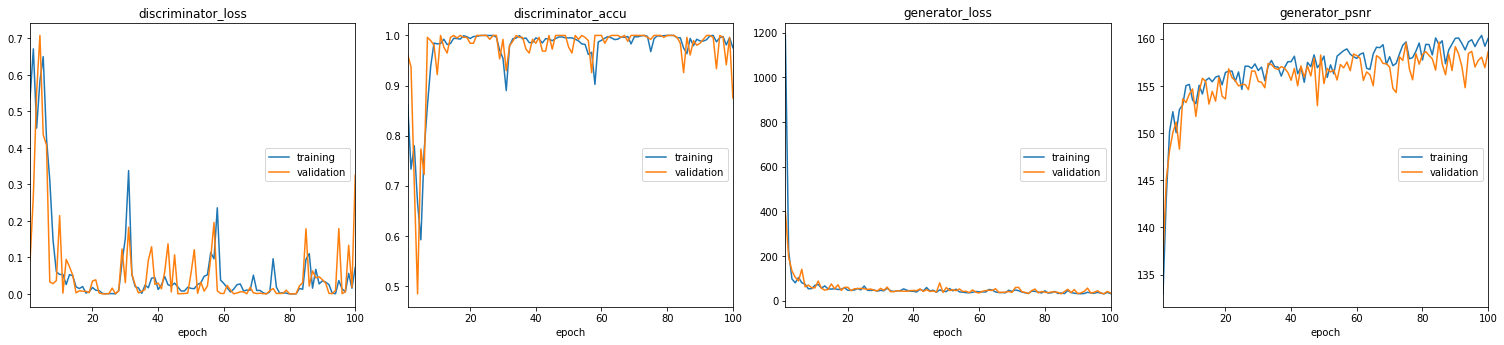

100%|██████████| 100/100 [12:16<00:00,  7.40s/epoch, discriminator_loss=0.0726, discriminator_accu=0.975, generator_loss=31, generator_psnr=160, val_discriminator_loss=0.325, val_discriminator_accu=0.875, val_generator_loss=33.7, val_generator_psnr=159]

In [23]:
epochs = 100

metric_names = [
    "discriminator_loss",
    "discriminator_accu",
    "generator_loss",
    "generator_psnr",
]
columns = metric_names + [f"val_{metric_name}" for metric_name in metric_names]
dataframe = pd.DataFrame(index=np.arange(epochs), columns=columns)
progressbar = tqdm.tqdm(unit="epoch", total=epochs, position=0)

train_iter.reset()
dev_iter.reset()

for i in range(epochs):
    metrics_dict = {mn: [] for mn in columns}  # reset metrics dictionary

    ## Part 1 - Training on training dataset
    while i == train_iter.epoch:  # while we are in epoch i, run minibatch training
        train_batch = train_iter.next()
        train_arrays = chainer.dataset.concat_examples(batch=train_batch)
        ## 1.1 - Train Discriminator
        d_train_loss, d_train_accu = train_eval_discriminator(
            input_arrays=train_arrays,
            g_model=generator_model,
            d_model=discriminator_model,
            d_optimizer=discriminator_optimizer,
        )
        metrics_dict["discriminator_loss"].append(d_train_loss)
        metrics_dict["discriminator_accu"].append(d_train_accu)

        ## 1.2 - Train Generator
        g_train_loss, g_train_psnr = train_eval_generator(
            input_arrays=train_arrays,
            g_model=generator_model,
            d_model=discriminator_model,
            g_optimizer=generator_optimizer,
        )
        metrics_dict["generator_loss"].append(g_train_loss)
        metrics_dict["generator_psnr"].append(g_train_psnr)

    ## Part 2 - Evaluation on development dataset
    while i == dev_iter.epoch:  # while we are in epoch i, evaluate on each minibatch
        dev_batch = dev_iter.next()
        dev_arrays = chainer.dataset.concat_examples(batch=dev_batch)
        ## 2.1 - Evaluate Discriminator
        d_train_loss, d_train_accu = train_eval_discriminator(
            input_arrays=dev_arrays,
            g_model=generator_model,
            d_model=discriminator_model,
            train=False,
        )
        metrics_dict["val_discriminator_loss"].append(d_train_loss)
        metrics_dict["val_discriminator_accu"].append(d_train_accu)

        ## 2.2 - Evaluate Generator
        g_dev_loss, g_dev_psnr = train_eval_generator(
            input_arrays=dev_arrays,
            g_model=generator_model,
            d_model=discriminator_model,
            train=False,
        )
        metrics_dict["val_generator_loss"].append(g_dev_loss)
        metrics_dict["val_generator_psnr"].append(g_dev_psnr)

    ## Part 3 - Plot loss and metric information using livelossplot
    dataframe.loc[i] = [np.mean(metrics_dict[metric]) for metric in dataframe.keys()]
    livelossplot.draw_plot(
        logs=dataframe.to_dict(orient="records"),
        metrics=metric_names,
        max_cols=4,
        figsize=(21, 9),
        max_epoch=epochs,
    )
    progressbar.set_postfix(ordered_dict=dataframe.loc[i].to_dict())
    experiment.log_metrics(dic=dataframe.loc[i].to_dict(), step=i)
    progressbar.update(n=1)

In [24]:
model = generator_model

In [25]:
os.makedirs(name="model/weights", exist_ok=True)
# Save generator model's parameter weights in Numpy Zipped format
chainer.serializers.save_npz(
    file="model/weights/srgan_generator_model_weights.npz", obj=model
)
# Save generator model's architecture in ONNX format
dummy_inputs = {
    "x": np.random.rand(32, 1, 10, 10).astype("float32"),
    "w1": np.random.rand(32, 1, 100, 100).astype("float32"),
    "w2": np.random.rand(32, 1, 20, 20).astype("float32"),
}
_ = onnx_chainer.export(
    model=model,
    args={"inputs": dummy_inputs},
    filename="model/weights/srgan_generator_model_architecture.onnx",
    export_params=False,
    save_text=True,
)

# Upload model weights file to Comet.ML and finish Comet.ML experiment
experiment.log_asset(
    file_path="model/weights/srgan_generator_model_weights.npz",
    file_name="srgan_generator_model_weights.npz",
)

# 4. Evaluate model

## Evaluation on independent test set

In [26]:
def get_deepbedmap_test_result(test_filepath: str = "highres/2007tx"):
    """
    Gets Root Mean Squared Error of elevation difference between
    DeepBedMap topography and reference groundtruth xyz tracks
    at a particular test region
    """
    deepbedmap = _load_ipynb_modules("deepbedmap.ipynb")

    # Get groundtruth images, window_bounds and neural network input datasets
    groundtruth, window_bound = deepbedmap.get_image_and_bounds(f"{test_filepath}.nc")
    X_tile, W1_tile, W2_tile = deepbedmap.get_deepbedmap_model_inputs(
        window_bound=window_bound
    )

    # Run input datasets through trained neural network model
    model = deepbedmap.load_trained_model()
    Y_hat = model.forward(inputs={"x": X_tile, "w1": W1_tile, "w2": W2_tile}).array

    # Save infered deepbedmap to grid file(s)
    deepbedmap.save_array_to_grid(
        window_bound=window_bound, array=Y_hat, outfilepath="model/deepbedmap3"
    )

    # Load xyz table for test region
    data_prep = _load_ipynb_modules("data_prep.ipynb")
    track_test = data_prep.ascii_to_xyz(pipeline_file=f"{test_filepath}.json")
    track_test.to_csv("track_test.xyz", sep="\t", index=False)

    # Get the elevation (z) value at specified x, y points along the groundtruth track
    !gmt grdtrack track_test.xyz -Gmodel/deepbedmap3.nc -h1 -i0,1,2 > track_deepbedmap3.xyzi
    df_deepbedmap3 = pd.read_table(
        "track_deepbedmap3.xyzi", header=1, names=["x", "y", "z", "z_interpolated"]
    )

    # Calculate elevation error between groundtruth xyz tracks and deepbedmap
    df_deepbedmap3["error"] = df_deepbedmap3.z_interpolated - df_deepbedmap3.z
    rmse_deepbedmap3 = (df_deepbedmap3.error ** 2).mean() ** 0.5

    return rmse_deepbedmap3

In [27]:
rmse_test = get_deepbedmap_test_result()
print(f"Experiment yielded Root Mean Square Error of {rmse_test:.2f} on test set")
experiment.log_metric(name="rmse_test", value=rmse_test)

Tiling: lowres/bedmap2_bed.tif
Tiling: misc/REMA_100m_dem.tif
Tiling: misc/MEaSUREs_IceFlowSpeed_450m.tif
Experiment yielded Root Mean Square Error of 109.77 on test set


In [28]:
experiment.end()

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/weiji14/deepbedmap/4eba898b6160449a8fae53e58094c904

